In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
from init_objects import *
from functions.helpers import organise_data, hypothetical_series, get_specific_bootstraps_moments, confidence_interval
from functions.inequality import gini
from model import *
import statsmodels.api as sm
from matplotlib import style
from functions.evolutionaryalgo import *
import scipy.stats as stats
from SALib.sample import latin

In [2]:
style.use('seaborn-ticks')

# Asset price volatility and wealth inequality

This notebook contains the following steps:

1. Parameter calibration and estimation
2. Model dynamics
3. Experiment

## 1 Parameter calibration and estimation

### 1.1 Collect data

In [3]:
shiller_data = pd.read_excel('http://www.econ.yale.edu/~shiller/data/ie_data.xls', header=7)[:-3]
p = pd.Series(np.array(shiller_data.iloc[1174:-1]['Price'])) #starting in 1952  was 1224
price_div = pd.Series(np.array(shiller_data.iloc[1174:-1]['CAPE']))
p_returns = pd.Series(np.array(shiller_data.iloc[1174:]['Price'])).pct_change()[1:]
pd_returns = pd.Series(np.array(shiller_data.iloc[1174:]['CAPE'])).pct_change()[1:]

### 1.2 calibration

First, I set two parameters for computational efficiency

Then, I calibrate parameters using data and literature. 

In [4]:
params = {"trader_sample_size": 10, # selected for comp efficiency
          "n_traders": 1000, # selected for comp efficiency
          "init_stocks": int((21780000000 / 267.33) / float(1000000)), # market valuation of Vanguard S&P 500 / share price 
          "ticks": len(p), # lenght of reference data
          "fundamental_value": p.mean(), # average value of reference data, assuming efficient markets
          "std_fundamental": p_returns.std(), # standard deviation of returns sp price, assuming efficient markets
          "base_risk_aversion": 0.7, # estimate from Kim & Lee (2012)
          'spread_max': 0.004087, # estimate from Riordan & Storkenmaier (2012)
          "horizon": int(len(p) * 0.35), # estimate based on average churn ratio found by Cella, Ellul and Giannetti (2013)
          "std_noise": 0.01, 
          "w_random": 1.0, 
          # parameter only used for experiment
          "mean_reversion": 0.0,
          # fixed / not modelled parameters
          "fundamentalist_horizon_multiplier": 1.0,
          "strat_share_chartists": 0.0,
          "mutation_intensity": 0.0,
          "average_learning_ability": 0.0,
          "trades_per_tick": 1
         }

In [5]:
params

{'trader_sample_size': 10,
 'n_traders': 1000,
 'init_stocks': 81,
 'ticks': 606,
 'fundamental_value': 1112.2356754564078,
 'std_fundamental': 0.036106530849401956,
 'base_risk_aversion': 0.7,
 'spread_max': 0.004087,
 'horizon': 212,
 'std_noise': 0.01,
 'w_random': 1.0,
 'mean_reversion': 0.0,
 'fundamentalist_horizon_multiplier': 1.0,
 'strat_share_chartists': 0.0,
 'mutation_intensity': 0.0,
 'average_learning_ability': 0.0,
 'trades_per_tick': 1}

Finally, there are two parameters left which are difficult to calibrate. Therefore, I estimate these values using the method of simulated moments. The starting point of this method is finding appropriate moments which the model should be able to replicate. I note that there should be more moments than parameters. Since 2 parameters need to be estimated, 3 moments are needed. Since this is a highly stylized model, I am only interested in the model replicating some basic moments of the price return series. The parameters are the average, standard deviation and average autocorrelation over 25 lags. 

First, I calculate these moments for the empirical data. 

In [6]:
emp_moments = np.array([
    p_returns.mean(),
    #p_returns.std(),
    autocorrelation_returns(p_returns, 25),
    ])
emp_moments

array([0.00284313, 0.0094694 ])

To account for the fact that some of these moments might correlate over different Monte Carlo Simulations, the MSM seeks to obtain a variance covariance matrix of the moments. Since there is only one empirical reality, I use a bootstrap procedure to create a covariance matrix of empirical moments. For this, I use a block bootstrap procedure.

In [7]:
BLOCK_SIZE = 25
BOOTSTRAPS = 100

In [10]:
p_data_blocks = []
for x in range(0, len(p_returns[:-3]), BLOCK_SIZE):
    p_data_blocks.append(p_returns[x:x + BLOCK_SIZE])

In [11]:
bootstrapped_p_returns = []
for i in range(BOOTSTRAPS):
    sim_data_p = [random.choice(p_data_blocks) for _ in p_data_blocks]
    sim_data2_p = [j for i in sim_data_p for j in i]
    bootstrapped_p_returns.append(sim_data2_p)

In [12]:
rets_mean = []
rets_std = []
rets_autocor = []

for rets in bootstrapped_p_returns:
    rets_mean.append(pd.Series(rets).mean())
    #rets_std.append(pd.Series(rets).std())
    rets_autocor.append(autocorrelation_returns(rets, 25))

In [13]:
all_bootstrapped_moments = [rets_mean,
                            #rets_std,
                            rets_autocor
                           ]

In [14]:
av_moments = [np.nanmean(x) for x in all_bootstrapped_moments]
moments_b = [get_specific_bootstraps_moments(all_bootstrapped_moments, n) for n in range(len(bootstrapped_p_returns))]

Here, I follow [Franke & Westerhoff 2016](https://link.springer.com/article/10.1007/s11403-014-0140-6#Sec8) in that I use the inverse of the bootstrap estimate of the moment covariance matrix as my weights.

In [15]:
W_hat = 1.0 / len(bootstrapped_p_returns) * sum([np.dot(np.array([(mb - av_moments)]).transpose(), np.array([(mb - av_moments)])) for mb in moments_b])
W = np.linalg.inv(W_hat)
np.save('distr_weighting_matrix', W)

I establish confidence intervals for the moments

In [16]:
confidence_intervals = [confidence_interval(m, emp) for m, emp in zip(all_bootstrapped_moments, emp_moments)]

In [17]:
j_values = []
for b in moments_b:
    j_values.append(quadratic_loss_function(b, emp_moments, W))

In [18]:
scores = [0 for x in moments_b[0]]
for bootstr in range(len(moments_b)):
    for idx, moment in enumerate(moments_b[bootstr]):
        if moment > confidence_intervals[idx][0] and moment < confidence_intervals[idx][1]:
            scores[idx] += 1
MCR_bootstrapped_moments = np.array(scores) / (np.ones(len(scores)) * len(moments_b))

To start the estimation procedure, I first sample the parameter space using Latin Hypercube sampling

In [6]:
population_size = 1

In [8]:
problem = {
  'num_vars': 1,
  'names': ['std_noise'],#,
            #'w_random'],
  'bounds': [[0.05, 0.20]]#,
             #[0.02, 0.20]]
}

In [9]:
latin_hyper_cube = latin.sample(problem=problem, N=population_size)
latin_hyper_cube = latin_hyper_cube.tolist()
with open('hypercube.txt', 'w') as f:
    json.dump(latin_hyper_cube, f)
initial_params = latin_hyper_cube[0]
initial_params

[0.12668789035270533]

I perform the estimation excercise in a different Python file using multi-processing. I download the resulting paramters below.

In [9]:
with open('estimated_params.json', 'r') as f:
    est_params = json.loads(f.read())

In [10]:
for i, name in enumerate(problem['names']):
    params[name] = est_params[i]

In [87]:
params['n_traders'] = 50

In [88]:
# params['std_noise'] = 5.59
# params['w_random'] = 0.19

# Volatility inequality model

In [89]:
#params['std_noise'] = 2.0

In [90]:
NRUNS = 10

In [91]:
trdrs0 = []
orbs0 = []
gini_ends = []
end_ticks = []
for seed in range(NRUNS): 
    traders0, orderbook0 = init_objects_unequal(params, seed, equality=1.0)
    traders0, orderbook0, gini_end, end_tick = volatility_inequality_model_equilibrium(traders0, orderbook0, params, seed, cancel_all_orders=True)
    trdrs0.append(traders0)
    orbs0.append(orderbook0)
    gini_ends.append(gini_end)
    end_ticks.append(end_tick)

Start of simulation  0
Simulation ends in tick  6166  with Gini  0.9003996382047944
Start of simulation  1
Simulation ends in tick  7249  with Gini  0.9005922412272901
Start of simulation  2
Simulation ends in tick  6263  with Gini  0.9007091775427745
Start of simulation  3
Simulation ends in tick  6471  with Gini  0.9006768881216038
Start of simulation  4
Simulation ends in tick  5259  with Gini  0.9006028128268544
Start of simulation  5
Simulation ends in tick  6786  with Gini  0.9010595566795698
Start of simulation  6
Simulation ends in tick  7701  with Gini  0.900102053341065
Start of simulation  7
Simulation ends in tick  5911  with Gini  0.9005214080800823
Start of simulation  8
Simulation ends in tick  7743  with Gini  0.9000004749171332
Start of simulation  9
Simulation ends in tick  5996  with Gini  0.9009242432044544


In [103]:
print(np.mean(end_ticks))
print(confidence_interval(end_ticks, np.mean(end_ticks)))

6554.5
(6052.750659690232, 7056.249340309768)


In [92]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs0, burn_in_period=0)

In [93]:
#mc_prices[0].pct_change().std()

In [117]:
lower_c_price = []
upper_c_price = []
for row in range(min(series_length)-2):
    price_range = mc_prices.iloc[row]# / mc_fundamentals.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(max(lower, 0.0))
    upper_c_price.append(upper)

5258

Identify individual wealth changes

In [96]:
series_length = []
for col in mc_prices:
    try:
        series_length.append(mc_prices[mc_prices[col].isna()].index[0])
    except:
        series_length.append(len(mc_prices))

In [97]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
profits = []
real_profits = []
market_returns = []

# determine the start and end wealth
for seed, traders in enumerate(trdrs0):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs0[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs0[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    real_profits.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs0[seed].tick_close_price[-1] - orbs0[seed].tick_close_price[0]) / orbs0[seed].tick_close_price[0] for x in range(len(wealth_start))])

    wealth_gini_over_time = []
    palma_over_time = []
    for t in range(min(series_length) - 1):
        #print(t)
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs0[seed].tick_close_price[t])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)

In [98]:
av_gini_ot = []
low_gini_ot = []
up_gini_ot = []

av_palma_ot = []
low_palma_ot = []
up_palma_ot = []

for t in range(min(series_length)-1):
    t_gini = [g[t] for g in ginis_ot]
    av_gini_ot.append(np.mean(t_gini))
    low, up = confidence_interval(t_gini, np.mean(t_gini))
    low_gini_ot.append(low)
    up_gini_ot.append(up)

    t_palma = [p[t] for p in palmas_ot]
    av_palma_ot.append(np.mean(t_palma))
    low, up = confidence_interval(t_palma, np.mean(t_palma))
    low_palma_ot.append(low)
    up_palma_ot.append(up)

# Does the noise trader model tend towards an unequal steady state?

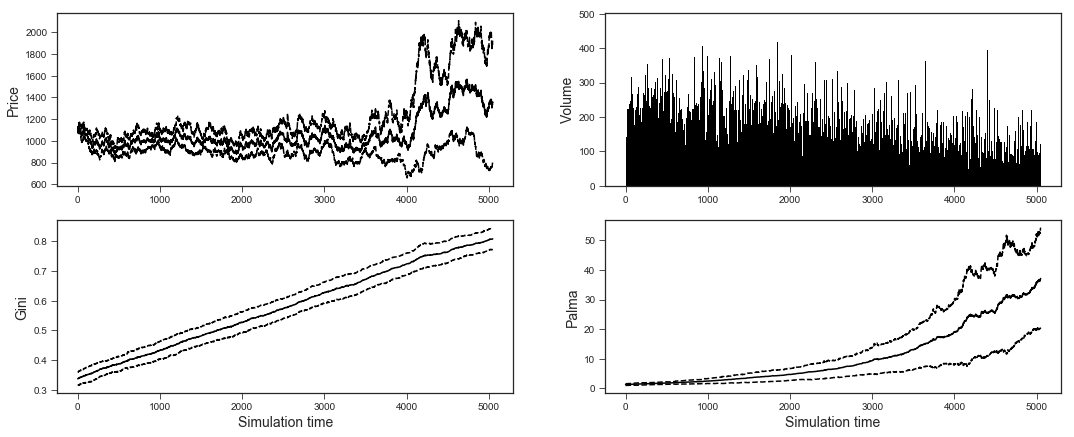

In [118]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(18,7))

#ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), label='Fundamental')
#ax1.plot(mc_prices.index, (mc_prices.mean(axis=1) / mc_fundamentals.mean(axis=1))[:], label='Market')
ax1.plot(mc_prices.iloc[:min(series_length)-1].index, mc_prices.iloc[:min(series_length)-1].mean(axis=1), 'k', label='Market')
ax1.plot(mc_prices.iloc[:min(series_length)-1].index[:-1], lower_c_price, 'k--')
ax1.plot(mc_prices.iloc[:min(series_length)-1].index[:-1], upper_c_price, 'k--')
#ax1.legend(loc='best', fontsize='14')

ax1.set_ylabel('Price', fontsize='14')

ax2.bar(mc_volume.iloc[:min(series_length)-1].index, mc_volume.iloc[:min(series_length)-1].mean(axis=1), width=1.0, color='black')
ax2.set_ylabel('Volume', fontsize='14')

ax3.plot(range(len(av_gini_ot[:])), av_gini_ot[:], 'k')
ax3.plot(range(len(low_gini_ot[:])), low_gini_ot[:], 'k--')
ax3.plot(range(len(up_gini_ot[:])), up_gini_ot[:], 'k--')
ax3.set_ylabel('Gini', fontsize='14')

ax4.plot(range(len(av_gini_ot[:])), av_palma_ot[:], 'k')
ax4.plot(range(len(low_gini_ot[:])), low_palma_ot[:], 'k--')
ax4.plot(range(len(up_gini_ot[:])), up_palma_ot[:], 'k--')
ax4.set_ylabel('Palma', fontsize='14')


for ax in (ax3, ax4):
    ax.set_xlabel('Simulation time', fontsize='14')
    
#ax3.set_xlabel('Agents', fontsize='14')

fig.savefig('baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Do individual traders see their wealth diminish below a lower bound

In [122]:
# lower_bound = price
perc_traders_lower_bound_ot = []
for seed, traders in enumerate(trdrs0):
    perc_traders_lower_bound = []
    for t in range(min(series_length) - 1):
        #print(t)
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs0[seed].tick_close_price[t])

        sorted_wealth = np.sort(wealth)
        cumsum_wealth = pd.Series(np.cumsum(sorted_wealth) / sum(wealth))
        perc_traders_bottom20 = cumsum_wealth[cumsum_wealth > 0.1].index[0] / float(len(wealth))
        perc_traders_lower_bound.append(perc_traders_bottom20)
    
    perc_traders_lower_bound_ot.append(perc_traders_lower_bound)

In [123]:
av_perc_tr_lb = []
low_perc_tr_lb = []
high_perc_tr_lb = []

for t in range(min(series_length)-1):
    t_ptlb = [g[t] for g in perc_traders_lower_bound_ot]
    av_perc_tr_lb.append(np.mean(t_ptlb))
    low, up = confidence_interval(t_ptlb, np.mean(t_ptlb))
    low_perc_tr_lb.append(low)
    high_perc_tr_lb.append(up)

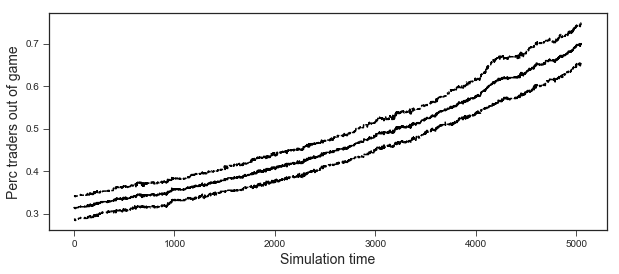

In [129]:
# what I want to measure: people are getting too poor to trade 
fig, ax = plt.subplots(1, 1, figsize=(10,4))

ax.plot(range(len(av_perc_tr_lb[:])), av_perc_tr_lb[:], 'k')
ax.plot(range(len(low_perc_tr_lb[:])), low_perc_tr_lb[:], 'k--')
ax.plot(range(len(high_perc_tr_lb[:])), high_perc_tr_lb[:], 'k--')
ax.set_ylabel('Perc traders out of game', fontsize='14')



ax.set_xlabel('Simulation time', fontsize='14')
    
#ax3.set_xlabel('Agents', fontsize='14')

fig.savefig('rise_of_poverty.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Experiment 

In [133]:
stdev_fun = [x / 100.0 for x in range(0, 100, 5)]

In [144]:
stdev_fun = stdev_fun[1:7]

In [20]:
#params['ticks'] = 600

In [141]:
NRUNS = 5

In [142]:
#stdev_fun[0] = 0.0001

In [145]:
stdev_fun

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

In [146]:
experiments = len(stdev_fun)

In [147]:
trdrs = []
orbs = []
gini_ends1 = []
end_ticks1 = []

for exp in range(experiments):
    #params['std_fundamental'] = stdev_fun[exp]
    params['std_noise'] = stdev_fun[exp]
    for seed in range(NRUNS): 
        traders, orderbook = init_objects_distr(params, seed)
        traders, orderbook, gini_end, end_tick = volatility_inequality_model_equilibrium(traders, orderbook, params, seed, cancel_all_orders=True)
        trdrs.append(traders)
        orbs.append(orderbook)
        gini_ends1.append(gini_end)
        end_ticks1.append(end_tick)

C:\Users\joerischasfoort\Documents\GitHub\asset_volatility_wealth_inequality\functions\helpers.py:31: RuntimeWarning: invalid value encountered in true_divide
  answer = np.true_divide(numerator, denominator)


Start of simulation  0
Simulation ends in tick  9153  with Gini  0.900838821982659
Start of simulation  1
Simulation ends in tick  8882  with Gini  0.9000132987552423
Start of simulation  2
Simulation ends in tick  8529  with Gini  0.900162230410708
Start of simulation  3
Simulation ends in tick  8130  with Gini  0.9000485572506283
Start of simulation  4
Simulation ends in tick  8377  with Gini  0.9007379759511916
Start of simulation  0
Simulation ends in tick  3719  with Gini  0.90043807833337
Start of simulation  1
Simulation ends in tick  4849  with Gini  0.9000857382892434
Start of simulation  2
Simulation ends in tick  5056  with Gini  0.9005849663366357
Start of simulation  3
Simulation ends in tick  4141  with Gini  0.9000630552745931
Start of simulation  4
Simulation ends in tick  4948  with Gini  0.9002379773214907
Start of simulation  0
Simulation ends in tick  3469  with Gini  0.9004569420442519
Start of simulation  1
Simulation ends in tick  3139  with Gini  0.9013931394437

In [148]:
print(np.mean(end_ticks))
print(confidence_interval(end_ticks, np.mean(end_ticks)))

6554.5
(6052.750659690232, 7056.249340309768)


In [157]:
experiments * NRUNS

30

In [158]:
len(end_ticks1)

30

In [159]:
av_exp_ends = []
lo_exp_ends = []
hi_exp_ends = []

for x in range(experiments):
    y = x*NRUNS
    ends = end_ticks1[y:y+NRUNS]
    
    av_exp_ends.append(np.mean(ends))
    low, up = confidence_interval(ends, np.mean(ends))
    lo_exp_ends.append(low)
    hi_exp_ends.append(up)

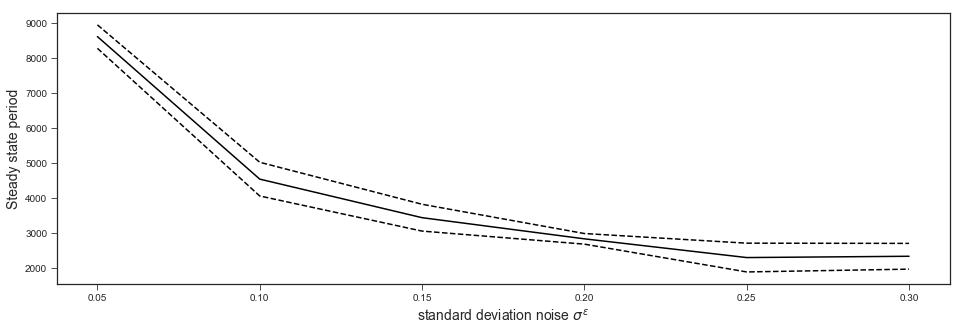

In [160]:
fig, ax = plt.subplots(1, 1, figsize=[16,5])

ax.plot(stdev_fun, av_exp_ends, 'k')
ax.plot(stdev_fun, lo_exp_ends, 'k--')
ax.plot(stdev_fun, hi_exp_ends, 'k--')

ax.set_ylabel('Steady state period', fontsize=14)
ax.set_xlabel('standard deviation noise $\sigma^{\epsilon}$', fontsize=14)

fig.savefig('experiment_high_vol_quick_ineq.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Old stuff below

In [26]:
full_stdev_fun = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_stdev_fun.append(stdev_fun[exp])

In [27]:
ginis = []
palmas = []

for idx, traders in enumerate(trdrs):
    money = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    ginis.append(gini(wealth))

In [28]:
# calc redistribution, profits ... abs 
profits = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))

In [29]:
# split the data in parts of 10 
gini_averages = []
gini_conf_interval_uppers = []
gini_conf_intervals_lowers = []

palma_averages = []
palma_conf_interval_uppers = []
palma_conf_intervals_lowers = []

for x in range(experiments):
    y = x*NRUNS
    g = ginis[y:y+NRUNS]
    
    gini_averages.append(np.mean(g))
    sample_stdev = np.std(g)
    sigma = sample_stdev/math.sqrt(len(g))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(g), scale = sigma) 
    gini_conf_interval_uppers.append(min(upper, 1.0))
    gini_conf_intervals_lowers.append(lower)
    
    p = palmas[y:y+NRUNS]
    palma_averages.append(np.mean(p))
    sample_stdev = np.std(p)
    sigma = sample_stdev/math.sqrt(len(p))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p), scale = sigma) 
    palma_conf_interval_uppers.append(upper)
    palma_conf_intervals_lowers.append(max(lower, 0))

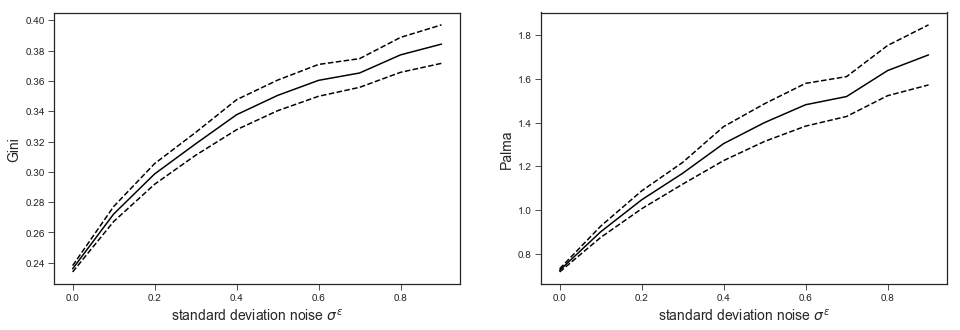

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,5])

ax1.plot(stdev_fun, gini_averages, 'k')
ax1.plot(stdev_fun, gini_conf_interval_uppers, 'k--')
ax1.plot(stdev_fun, gini_conf_intervals_lowers, 'k--')

ax2.plot(stdev_fun, palma_averages, 'k')
ax2.plot(stdev_fun, palma_conf_interval_uppers, 'k--')
ax2.plot(stdev_fun, palma_conf_intervals_lowers, 'k--')

ax1.set_ylabel('Gini', fontsize=14)
ax2.set_ylabel('Palma', fontsize=14)

for ax in [ax1, ax2]:
    ax.set_xlabel('standard deviation noise $\sigma^{\epsilon}$', fontsize=14)

fig.savefig('stdev_f_inequality.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Robustness check what if money is reset at the end of every simulation.

Then the effect disappears.

In [31]:
trdrs_hypo = []
orbs_hypo = []
for seed in range(NRUNS): 
    traders_hypo, orderbook_hypo = init_objects_distr(params, seed)
    traders_hypo, orderbook_hypo = volatility_inequality_model_reset_wealth(traders_hypo, orderbook_hypo, params, seed)
    trdrs_hypo.append(traders_hypo)
    orbs_hypo.append(orderbook_hypo)

Start of simulation  0


KeyboardInterrupt: 

In [ ]:
for seed, traders in enumerate(trdrs_hypo):
    hypo_money_end = np.array([x.var.hypothetical_money[-1] for x in traders])
    hypo_stocks_end = np.array([x.var.hypothetical_stocks[-1] for x in traders])
    hypo_wealth_end = hypo_money_end + (hypo_stocks_end * orbs_hypo[seed].tick_close_price[-1])

In [ ]:
share_top_10 = sum(np.sort(hypo_wealth_end - min(hypo_wealth_end))[int(len(hypo_wealth_end - min(hypo_wealth_end)) * 0.9):]) / sum(hypo_wealth_end - min(hypo_wealth_end))
share_bottom_40 = sum(np.sort(hypo_wealth_end - min(hypo_wealth_end))[:int(len(hypo_wealth_end - min(hypo_wealth_end)) * 0.4)]) / sum(hypo_wealth_end - min(hypo_wealth_end))
share_top_10 / share_bottom_40

In [147]:
gini(hypo_wealth_end - min(hypo_wealth_end))

0.13408226618086494

# Experiment 

In [32]:
stdev_fun = [x / 100.0 for x in range(0, 100, 10)]

In [33]:
NRUNS = 25

In [34]:
stdev_fun[0] = 0.0001

In [35]:
stdev_fun

[0.0001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [36]:
experiments = len(stdev_fun)

In [37]:
#params['ticks'] = 1200

In [38]:
trdrs = []
orbs = []
for exp in range(experiments):
    #params['std_fundamental'] = stdev_fun[exp]
    params['std_noise'] = stdev_fun[exp]
    for seed in range(NRUNS): 
        traders, orderbook = init_objects_distr(params, seed)
        traders, orderbook = volatility_inequality_model_reset_wealth(traders, orderbook, params, seed)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  10
Start of simulation  11
Start of simulation  12
Start of simulation  13
Start of simulation  14
Start of simulation  15
Start of simulation  16
Start of simulation  17
Start of simulation  18
Start of simulation  19
Start of simulation  20
Start of simulation  21
Start of simulation  22
Start of simulation  23
Start of simulation  24
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  10
Start of simulation  11
Start of simulation  12
Start of simulation  13
Start of simulation  14
Start of simulation  15
Start of simulation  16
Start of sim

In [39]:
full_stdev_fun = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_stdev_fun.append(stdev_fun[exp])

In [40]:
ginis = []
palmas = []

for idx, traders in enumerate(trdrs):
    money = np.array([x.var.hypothetical_money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.hypothetical_stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    
    hypo_wealth = wealth - min(wealth)
    
    share_top_10 = sum(np.sort(hypo_wealth)[int(len(hypo_wealth) * 0.9):]) / sum(hypo_wealth)
    share_bottom_40 = sum(np.sort(hypo_wealth)[:int(len(hypo_wealth) * 0.4)]) / sum(hypo_wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    ginis.append(gini(hypo_wealth))

In [41]:
# split the data in parts of 10 
gini_averages = []
gini_conf_interval_uppers = []
gini_conf_intervals_lowers = []

palma_averages = []
palma_conf_interval_uppers = []
palma_conf_intervals_lowers = []

for x in range(experiments):
    y = x*NRUNS
    g = ginis[y:y+NRUNS]
    
    gini_averages.append(np.mean(g))
    sample_stdev = np.std(g)
    sigma = sample_stdev/math.sqrt(len(g))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(g), scale = sigma) 
    gini_conf_interval_uppers.append(min(upper, 1.0))
    gini_conf_intervals_lowers.append(lower)
    
    p = palmas[y:y+NRUNS]
    palma_averages.append(np.mean(p))
    sample_stdev = np.std(p)
    sigma = sample_stdev/math.sqrt(len(p))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p), scale = sigma) 
    palma_conf_interval_uppers.append(upper)
    palma_conf_intervals_lowers.append(max(lower, 0))

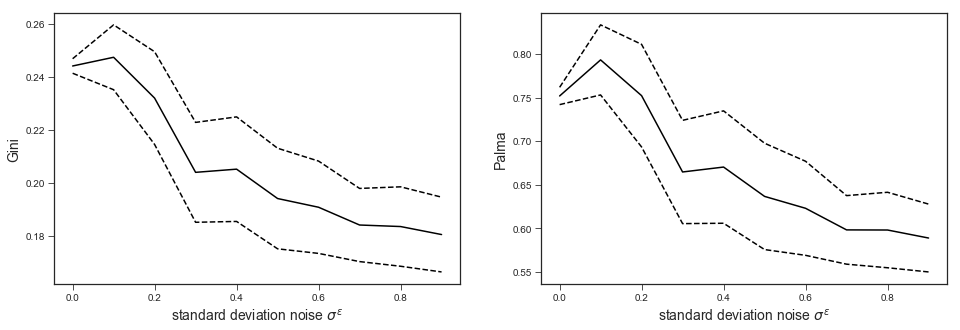

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,5])

ax1.plot(stdev_fun, gini_averages, 'k')
ax1.plot(stdev_fun, gini_conf_interval_uppers, 'k--')
ax1.plot(stdev_fun, gini_conf_intervals_lowers, 'k--')

ax2.plot(stdev_fun, palma_averages, 'k')
ax2.plot(stdev_fun, palma_conf_interval_uppers, 'k--')
ax2.plot(stdev_fun, palma_conf_intervals_lowers, 'k--')

ax1.set_ylabel('Gini', fontsize=14)
ax2.set_ylabel('Palma', fontsize=14)

for ax in [ax1, ax2]:
    ax.set_xlabel('standard deviation noise $\sigma^{\epsilon}$', fontsize=14)

fig.savefig('stdev_f_inequality_robustness_check.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Experiment with init inequality

In [224]:
init_equality = [x / 100.0 for x in range(10, 100, 20)]
init_equality = init_equality[::-1]
print(init_equality)

[0.9, 0.7, 0.5, 0.3, 0.1]


In [225]:
stdev_fun = [x / 100.0 for x in range(10, 100, 20)]
#stdev_fun[0] = 0.0001
stdev_fun

[0.1, 0.3, 0.5, 0.7, 0.9]

In [121]:
#params['std_noise'] = 0.4

In [226]:
NRUNS = 5

In [244]:
av_init_gini = []
av_init_palma = []
av_gini_diff = []
av_palma_diff = []
stdev_noise = []

#trdrs = []
#orbs = []
for std_exp in range(len(stdev_fun)):
    params['std_noise'] = stdev_fun[std_exp]
    for exp in range(len(init_equality)):
        init_gini = []
        gini_diffs = []
        init_palma = []
        palma_diffs = []
        
        equality = init_equality[exp]
        for seed in range(NRUNS): 
            traders, orderbook = init_objects_unequal(params, seed, equality)
            traders, orderbook = volatility_inequality_model2(traders, orderbook, params, seed)
            #trdrs.append(traders)
            #orbs.append(orderbook)
            
            money_start = np.array([x.var.money[0] for x in traders])
            stocks_start = np.array([x.var.stocks[0] for x in traders])
            wealth_start = money_start + (stocks_start * orbs[idx].tick_close_price[0])
            
            share_top_10 = sum(np.sort(wealth_start)[int(len(wealth_start) * 0.9):]) / sum(wealth_start)
            share_bottom_40 = sum(np.sort(wealth_start)[:int(len(wealth_start) * 0.4)]) / sum(wealth_start)
        
            init_palma.append(share_top_10 / share_bottom_40)
            init_gini.append(gini(wealth_start))

            money_end = np.array([x.var.money[-1] for x in traders])
            stocks_end = np.array([x.var.stocks[-1] for x in traders])
            wealth_end = money_end + (stocks_end * orbs[idx].tick_close_price[-1])
            
            end_share_top_10 = sum(np.sort(wealth_end)[int(len(wealth_end) * 0.9):]) / sum(wealth_end)
            end_share_bottom_40 = sum(np.sort(wealth_end)[:int(len(wealth_end) * 0.4)]) / sum(wealth_end)
            
            palma_diffs.append((end_share_top_10 / end_share_bottom_40 - share_top_10 / share_bottom_40) / share_top_10 / share_bottom_40)
            gini_diffs.append(gini(wealth_end) - gini(wealth_start))
        
        av_init_palma.append(np.mean(init_palma))
        av_palma_diff.append(np.mean(palma_diffs))
        
        av_init_gini.append(np.mean(init_gini))
        av_gini_diff.append(np.mean(gini_diffs))
        
        stdev_noise.append(stdev_fun[std_exp])

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of si

In [254]:
gini_data = pd.DataFrame({'delta Gini': av_gini_diff, 'initial Gini': av_init_gini, '$\sigma^{\epsilon}$': stdev_noise}).round(2)

In [255]:
gini_data = gini_data.pivot("initial Gini", "$\sigma^{\epsilon}$", "delta Gini")

In [262]:
palma_data = pd.DataFrame({'delta Palma': av_palma_diff, 'initial Palma': av_init_palma, '$\sigma^{\epsilon}$': stdev_noise}).round(2)

In [263]:
palma_data

,delta Palma,initial Palma,$\sigma^{\epsilon}$
0,1.592600e+02,1.42,0.1
1,2.547500e+02,2.17,0.1
2,6.403900e+02,4.50,0.1
3,7.319220e+03,22.27,0.1
4,2.061020e+10,45689.49,0.1
5,2.296900e+02,1.42,0.3
6,3.630000e+02,2.17,0.3
7,8.881900e+02,4.50,0.3
8,9.668250e+03,22.27,0.3
9,2.130156e+10,45689.49,0.3


In [257]:
palma_data = palma_data[palma_data['delta Palma']<10000]

In [258]:
palma_data = palma_data.pivot("initial Palma", "$\sigma^{\epsilon}$", "delta Palma")

In [148]:
import seaborn as sns 
sns.set()

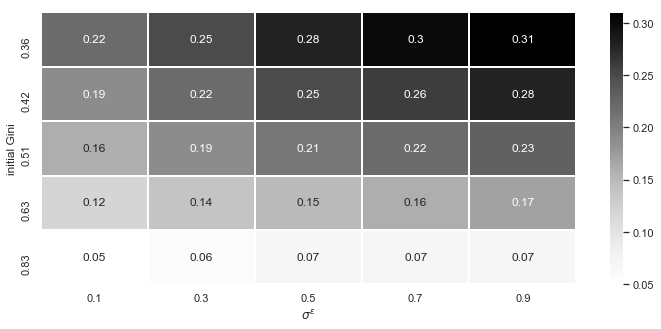

In [275]:
fig, ax1 = plt.subplots(1, 1, figsize=[12,5])

sns.heatmap(gini_data, cmap="Greys", ax=ax1, cbar=True, annot=True, linewidths=1, linecolor='white')
#sns.heatmap(palma_data, cmap="Greys", ax=ax2, cbar=True, annot=True)

fig.savefig('heatmap.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Sensitivity analysis

In [276]:
# TODO 